## Import and login

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import getpass

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)

config = SHConfig()
config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")

catalog = SentinelHubCatalog(config=config)

Enter your SentinelHub client id········
Enter your SentinelHub client secret········


## Evaluation scripts

In [4]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02","B03","B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04,sample.B03,sample.B02];
    }
"""

evalscript_B12 = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B12"]
            }],
            output: {
                bands: 1
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B12];
    }
"""

evalscript_B2 = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02"]
            }],
            output: {
                bands: 1
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B02];
    }
"""

In [5]:
class gaussian:
    
    def __init__(self,center,std,amp):
        self.center=center
        self.std=std
        self.amplitude=amp
        
    def std_normalized_distance_to(self,x,squared=False):
        d2=((self.center[0]-x[0])/self.std[0])**2+((self.center[1]-x[1])/self.std[1])**2
        if squared:
            return d2
        else:
            return d2**0.5

Class **matrix_data** for storing matrices of pixel values.
> Method ***clustering_with_threshhold*** to look for clusters of points that would correspond to a single event (e. g. bombing)

In [6]:
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm

class matrix_data:
    
    def __init__(self,data):
        self.data=data
        
    def clustering_with_threshhold(self,threshhold,eps=10,min_samples=5):
        
        if np.amax(self.data)<=threshhold:
            return []
        else:
            sh=self.data.shape
            res = np.zeros(sh)
            dat=[[x,y] for x in range(sh[0]) for y in range(sh[1]) if self.data[x,y]>threshhold]
            db = DBSCAN(eps=eps, min_samples=min_samples).fit(dat)
            labels = db.labels_
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
 
            unique_labels = set(labels)
            fig, ax = plt.subplots(figsize=(10,10))
            xys=[]
            for k in unique_labels:
                if not k=="-1":
                    class_member_mask = [i for i in range(len(labels)) if labels[i] == k]
                    xy=np.array([[dat[x][0],dat[x][1]] for x in class_member_mask])
                    ax.imshow(xy[:,0],xy[:,1],cmap=cm.plasma((int(k)/len(labels))))
                    #xy_sum=np.log(len(class_member_mask)+1)
                    #xy_mean=np.mean(xy,axis=0)
                    #xy_std=np.std(xy,axis=0)
                    #xys.append(gaussian(xy_mean,xy_std,xy_sum))
            fig.savefig("clusters.png")
            #return xys

Class **satellite_data** 

In [7]:
import matplotlib as mpl

class satellite_data:
    
    def __init__(self,date,bounding_box,aoi_size,heatmap_init=None):
        self.date=date
        self.bounding_box=bounding_box
        self.aoi_size=np.array(aoi_size)
        if heatmap_init is None:
            self.heatmap=np.zeros(self.aoi_size)
        else:
            self.heatmap=heatmap_init
        
    def update_with_data(self,true_color=None,B12=None,B2=None):
        if not true_color is None:
            self.true_color=matrix_data(true_color)
        if not B12 is None:
            self.B12=matrix_data(B12)
        if not B2 is None:
            self.B2=matrix_data(B2)
        
    def plot(self,factor=100,typs=["true_color"],alphas=["1.0"],threshholds=[None],cmaps=["grey"],grid_color="black",save_to=None):
        figsize = self.aoi_size/factor
        if figsize[0]>=2**16:
            figsize/=(figsize[0]/2**17)  
        if figsize[1]>=2**16:
            figsize/=(figsize[1]/2**17)
        fig, ax = plt.subplots(figsize=(figsize[0],figsize[1]))
        for i in range(len(typs)):
            if typs[i]=="true_color":
                im=self.true_color.data
            elif typs[i]=="B12":
                im=self.B12.data
            elif typs[i]=="B2":
                im=self.B2.data
            elif typs[i]=="heatmap":
                im=self.heatmap.data
            if typs[i]=="true_color":
                ax.imshow(im,alpha=alphas[i])
            else:
                if threshholds[i] is None:
                    ax.imshow(im,cmap=cmaps[i],alpha=alphas[i])
                else:
                    cmap=mpl.colormaps[cmaps[i]]
                    cmap._init()
                    cmap._lut[:,-1] = alphas[i]
                    ax.imshow(np.ma.masked_where((im<threshholds[i]),im).data,cmap=mpl.colormaps[cmaps[i]],alpha=alphas[i])
        if not save_to is None:
            fig.savefig(save_to)
            plt.close()
    
    def bombing_site_heatmap(self,threshhold_B12=0.75*255,threshhold_B2=0.75*255,eps=10,min_samples=5,min_distance_from_clouds=2,decay_parameter=0.95):
        xys_B12 = self.B12.clustering_with_threshhold(threshhold_B12,eps=eps,min_samples=min_samples)
        xys_B2 = self.B2.clustering_with_threshhold(threshhold_B2,eps=eps,min_samples=min_samples)
        sh=self.B12.data.shape
        heatmap = np.zeros(sh)
        for xy_B12 in xys_B12:
            cloud=False
            for xy_B2 in xys_B2:
                if(xy_B2.std_normalized_distance_to(xy_B12.center)<min_distance_from_clouds):
                    cloud=True
                    break
            if not cloud:
                for x in range(max(0,int(xy_B12.center[0]-3*xy_B12.std[0])),min(sh[0],1+int(xy_B12.center[0]+3*xy_B12.std[0]))):
                    for y in range(max(0,int(xy_B12.center[1]-3*xy_B12.std[1])),min(sh[1],1+int(xy_B12.center[1]+3*xy_B12.std[1]))):
                        heatmap[x,y]+=xy_B12.amplitude*np.exp(-xy_B12.std_normalized_distance_to([x,y]))
        
        self.heatmap=np.where(self.heatmap*decay_parameter+heatmap>255,255,self.heatmap+heatmap)
    
    def generate_matrix_data_from_file(self,file,file_bounding_box):
        W=np.genfromtxt("Wtest.txt",delimiter=",",missing_values=[None],filling_values=0,skip_header=1)
        if file_bounding_box[0]>self.bounding_box[0]:
            W=np.concatenate()
        W_data=matrix_data(W)

Class **war_zone** ...

Problem with plot_grid, something fishy about the grid lines, but it's very secondary at this point

In [8]:
import datetime

class war_zone:
    
    def __init__(self,east,south,west,north,crs=CRS.WGS84,resolution=10):
        self.bounding_box=[east,south,west,north]
        self.crs=crs
        self.resolution=resolution
        self.aoi_size = bbox_to_dimensions(BBox(bbox=self.bounding_box, crs=self.crs), resolution=self.resolution)
        self.easts = self.dim_to_2500(self.aoi_size[0])
        self.souths = self.dim_to_2500(self.aoi_size[1],NS=True)
        self.data={}
        #print(self.bounding_box)
        ##print(self.easts)
        #print(self.souths)
        #for e in self.easts:
        #    print(self.aoi_size[0]*(e-self.bounding_box[0])/(self.bounding_box[2]-self.bounding_box[0]))
        #print("s")
        #for s in self.souths:
        #    print(self.aoi_size[1]*(self.bounding_box[3]-s)/(self.bounding_box[3]-self.bounding_box[1]))
  
    def change_bounding_box(self,east,south,west,north):
        de=self.easts[1]-self.easts[0]
        ds=self.souths[1]-self.souths[0]
        self.bounding_box=[east,south,west,north]
        self.aoi_size = bbox_to_dimensions(BBox(bbox=self.bounding_box, crs=self.crs), resolution=self.resolution)
        while(self.bounding_box[0]<self.easts[0]):
            new_east_0=self.easts[0]-de
            self.easts=[new_east_0]+self.easts
        while(self.bounding_box[0]>self.easts[1]):
            self.easts=self.easts[1:]
        while(self.bounding_box[2]>self.easts[-1]):
            new_west_0=self.easts[-1]+de
            self.easts=self.easts+[new_west_0]
        while(self.bounding_box[2]<self.easts[-2]):
            self.easts=self.easts[:-1]
        while(self.bounding_box[1]<self.souths[0]):
            new_south_0=self.souths[0]-ds
            self.souths=[new_south_0]+self.souths
        while(self.bounding_box[1]>self.souths[1]):
            self.souths=self.souths[1:]
        while(self.bounding_box[3]>self.souths[-1]):
            new_north_0=self.souths[-1]+ds
            self.souths=self.souths+[new_north_0]
        while(self.bounding_box[3]<self.souths[-2]):
            self.souths=self.souths[:-1]
    
    def dim_to_2500(self,dim,NS=False):
        ind=int(NS)
        scl=dim/2500
        if dim>2500:
            subdivide=int(scl)+2
        else:
            subdivide=1
        dim=(self.bounding_box[2+ind]-self.bounding_box[ind])/scl
        shift=(subdivide%2)/2
        return [(self.bounding_box[ind]+self.bounding_box[2+ind])/2+(xi-shift)*dim for xi in range(-int(subdivide/2),int(subdivide/2)+1+(subdivide%2))]
            
    def plot_grid(self,ax,color="black",map_to_image=True,linewidth=10):
        for e in self.easts[1:-1]:
            if map_to_image:
                ax.axvline(x=self.aoi_size[0]*(e-self.bounding_box[0])/(self.bounding_box[2]-self.bounding_box[0]),color=color,linewidth=linewidth)
            else:
                ax.axvline(x=e,color=color,linewidth=linewidth)
        for s in self.souths[1:-1]:
            if map_to_image:
                ax.axhline(y=self.aoi_size[1]*(s-self.bounding_box[1])/(self.bounding_box[3]-self.bounding_box[1]),color=color,linewidth=linewidth)
            else:
                ax.axhline(y=s,color=color,linewidth=linewidth)
            
    def check_availability_for_date(self,date):
        aoi_bbox = BBox(bbox=self.bounding_box, crs=CRS.WGS84)
        #time_interval = date, str(datetime.date(int(date[0:4]),int(date[5:7]),int(date[8:10]))+datetime.timedelta(days=1))
        time_interval = date, date
        search_iterator = catalog.search(DataCollection.SENTINEL2_L2A,bbox=aoi_bbox,time=time_interval,fields={"include": ["id", "properties.datetime"], "exclude": []},)
        if len(list(search_iterator))>0:
            return time_interval, True
        else:
            return time_interval, False
        
    def download(self,date,typ="B12",heatmap_init=None):
        if not date in self.data.keys():
            self.data[date]=satellite_data(self.data,self.bounding_box,self.aoi_size,heatmap_init=heatmap_init)
        if typ=="true_color":
            script=evalscript_true_color
        elif typ=="B12":
            script=evalscript_B12
        elif typ=="B2":
            script=evalscript_B2
        time_interval, availability = self.check_availability_for_date(date)
        if not availability:
            print("No data for date {}".format(date))
        else:
            im = []
            for j in range(len(self.souths)-1):
                row=[]
                for i in range(len(self.easts)-1):
                    aoi_bbox = BBox(bbox=[self.easts[i],self.souths[j],self.easts[i+1],self.souths[j+1]], crs=self.crs)
                    request = SentinelHubRequest(evalscript=script,input_data=[SentinelHubRequest.input_data(data_collection=DataCollection.SENTINEL2_L2A.define_from(name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"), time_interval=(time_interval),other_args={"dataFilter": {"mosaickingOrder": "leastCC"}})],responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],bbox=aoi_bbox,size=(2500,2500),config=config)
                    image=request.get_data()[0]
                    row.append(image)
                im=[np.concatenate(list(r for r in row),axis=1)]+im
            final_im=np.concatenate(list(c for c in im))
            final_im=final_im[int(self.aoi_size[0]*(self.bounding_box[0]-self.easts[0])/(self.easts[-1]-self.easts[0])):-int(self.aoi_size[0]*(self.easts[-1]-self.bounding_box[2])/(self.easts[-1]-self.easts[0])),int(self.aoi_size[1]*(self.bounding_box[1]-self.souths[0])/(self.souths[-1]-self.souths[0])):-int(self.aoi_size[1]*(self.souths[-1]-self.bounding_box[3])/(self.souths[-1]-self.souths[0]))]
            if typ=="true_color":
                self.data[date].update_with_data(true_color=final_im)
            elif typ=="B12":
                self.data[date].update_with_data(B12=final_im)
            elif typ=="B2":
                self.data[date].update_with_data(B2=final_im,)

In [9]:
Gaza = war_zone(33.955307,31.240207,34.822540,31.570155)

## Warning

The code is presented here as developed during the hackathon. It's main drawback, which has not been addressed during that time, is that every call of the cell below will result in downloading the heavy satellite images from the SentinelHub, instead of checking if it is already stored on disk. Therefore, repeated running of this cell could lead not only to long execution time, but also to exhausting a monthly quota for satellite data download. A class **satellite_data** would have to be rebuilt to avoid this issue.

In [ ]:
Gaza.change_bounding_box(33.955307*0.4+34.822540*0.6,0.5*31.240207+0.5*31.570155,33.955307*0.1+34.822540*0.9,31.570155)
heatmap=np.zeros((3758,3837))
previous_date=2
for date in ["2023-10-07","2023-10-17","2023-10-22"]:
    print(date)
    interval, flag = Gaza.check_availability_for_date(date)
    if flag:
        print("Data available. Downloading true color")
        Gaza.download(date,typ="true_color",heatmap_init=heatmap)
        print("Downloading B12")
        Gaza.download(date,typ="B12",heatmap_init=heatmap)
        print("Downloading B2")
        Gaza.download(date,typ="B2",heatmap_init=heatmap)
        print("Downloading done, plotting")
        Gaza.data[date].plot(typs=["true_color","B2","B12"],alphas=[1.0,0.2,0.2],threshholds=[None,0.75,0.75],cmaps=[None,"twilight","hot_r"],save_to="./Gaza_true_B2_B12/{}.png".format(date))
        print("Generating a heatmap")
        current_date=int(date[8:10])
        Gaza.data[date].bombing_site_heatmap(min_distance_from_clouds=1.15,decay_parameter=1-0.01*(current_date-previous_date))
        previous_date=int(date[8:10])
        print("Previous date {}".format(previous_date))
        heatmap=Gaza.data[date].heatmap
        np.save("heatmap_{}.npy".format(date),heatmap)
        print("Plotting with heatmap")
        Gaza.data[date].plot(typs=["true_color","heatmap"],alphas=[1.0,0.5],threshholds=[None,None],cmaps=[None,"Reds"],save_to="./Gaza_true_heatmap/{}.png".format(date))
    else:
        print("No data available")

2023-10-07
Data available. Downloading true color


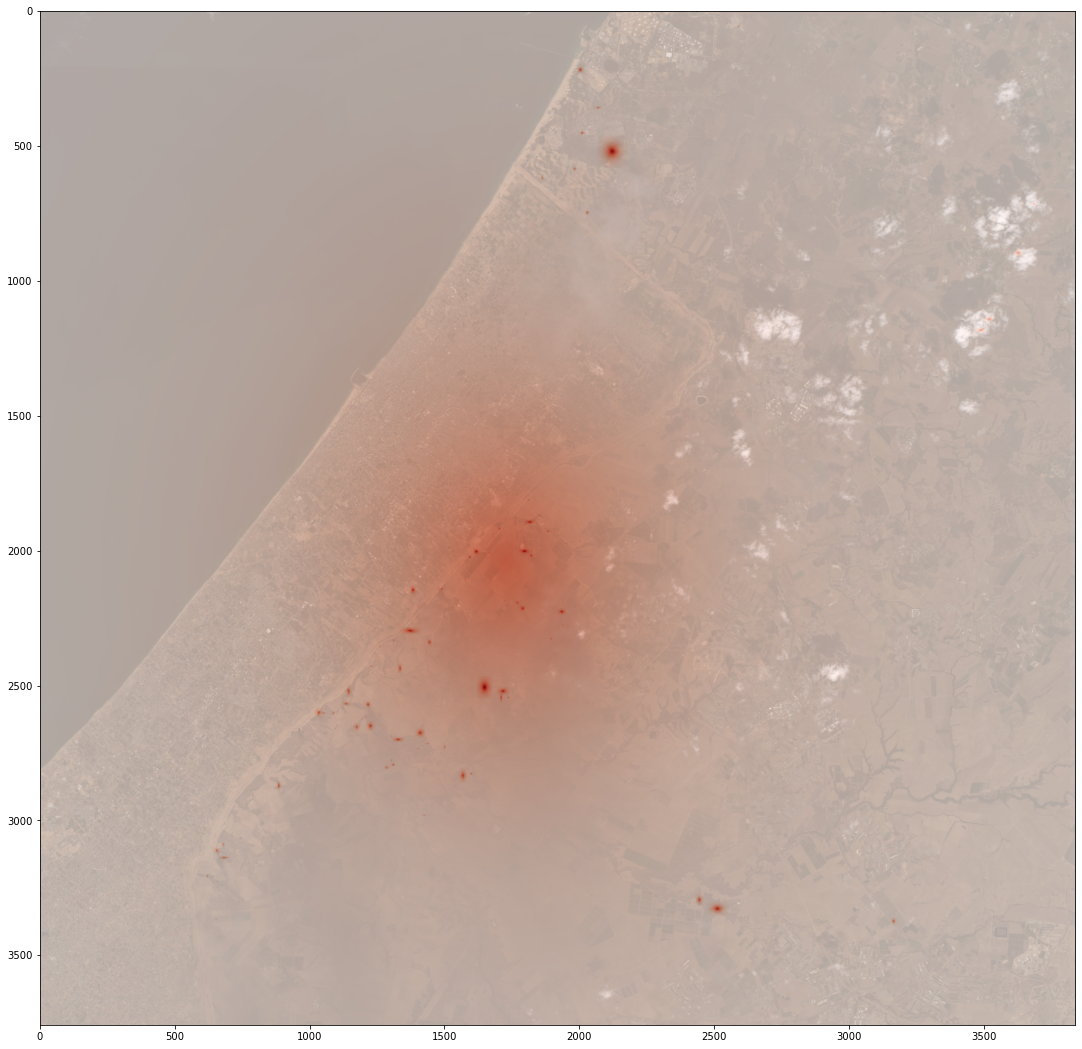

In [133]:
#list(map())
Gaza.data["2023-10-07"].plot(typs=["true_color","heatmap"],alphas=[1,0.7],threshholds=[None,None],cmaps=[None,"Reds"])